In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from glob import glob
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import seaborn as sns

In [53]:
#Задаем переменные директорий датасета и формируем списки путей к файлам
extn = '**\\*.jpg'
base_dir = 'fruits'
train_dir = base_dir + '\\train'
train_filepaths = list(glob(train_dir + '\\' + extn))

test_dir = base_dir + '\\test'
test_filepaths = list(glob(test_dir + '\\' +  extn))

val_dir = base_dir + '\\validation'
val_filepaths = list(glob(val_dir + '\\' +  extn))

In [54]:
def proc_img(filepath):
    # Извлекаем метки классов (названия папок) из путей к файлам
    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]
    # Преобразуем список путей к файлам в Pandas Series и задаем имя столбца 'Filepath'
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    # Преобразуем список меток (названий папок) в Pandas Series и задаем имя столбца 'Label'
    labels = pd.Series(labels, name='Label')

    # Объединяем столбцы filepath и labels в один DataFrame
    df = pd.concat([filepath, labels], axis=1)

    # Перемешиваем строки DataFrame и сбрасываем индексы
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# Применяем функцию для получения DataFrame для обучающих, тестовых и валидационных данных
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [55]:
# Визуализация количества изображений для каждой метки
def visualize_class_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='Label', data=df, order=df['Label'].value_counts().index)
    plt.title('Количество изображений для каждой метки')
    plt.xticks(rotation=90)
    plt.show()

# Вывод примера изображения для каждой метки
def show_example_images(df):
    unique_labels = df.copy().drop_duplicates(subset=["Label"]).reset_index()
    fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(unique_labels.Filepath[i]))
        ax.set_title(unique_labels.Label[i], fontsize = 12)
        ax.axis('off')
    
    plt.show()

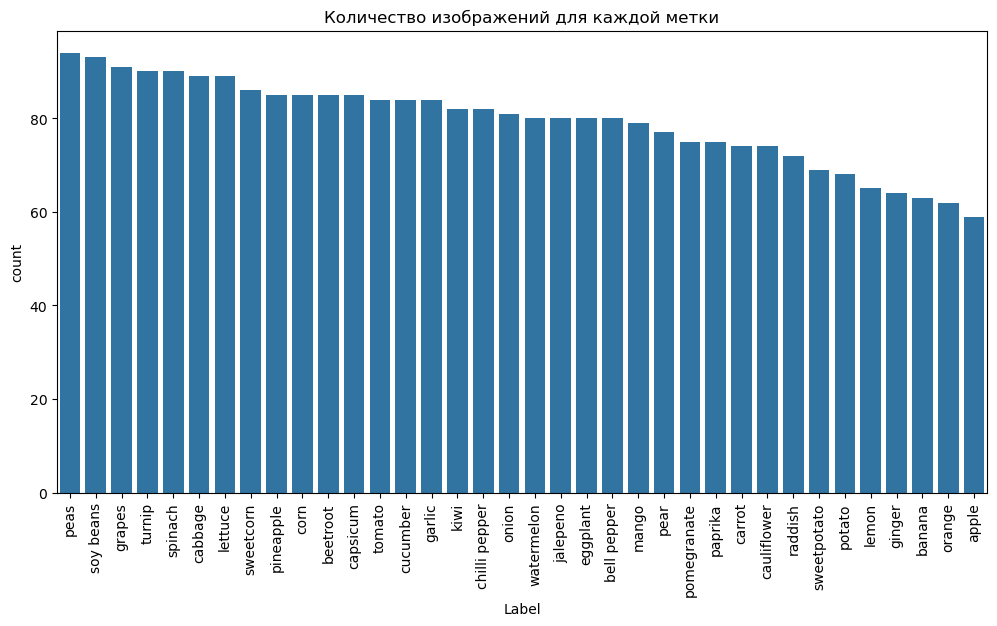

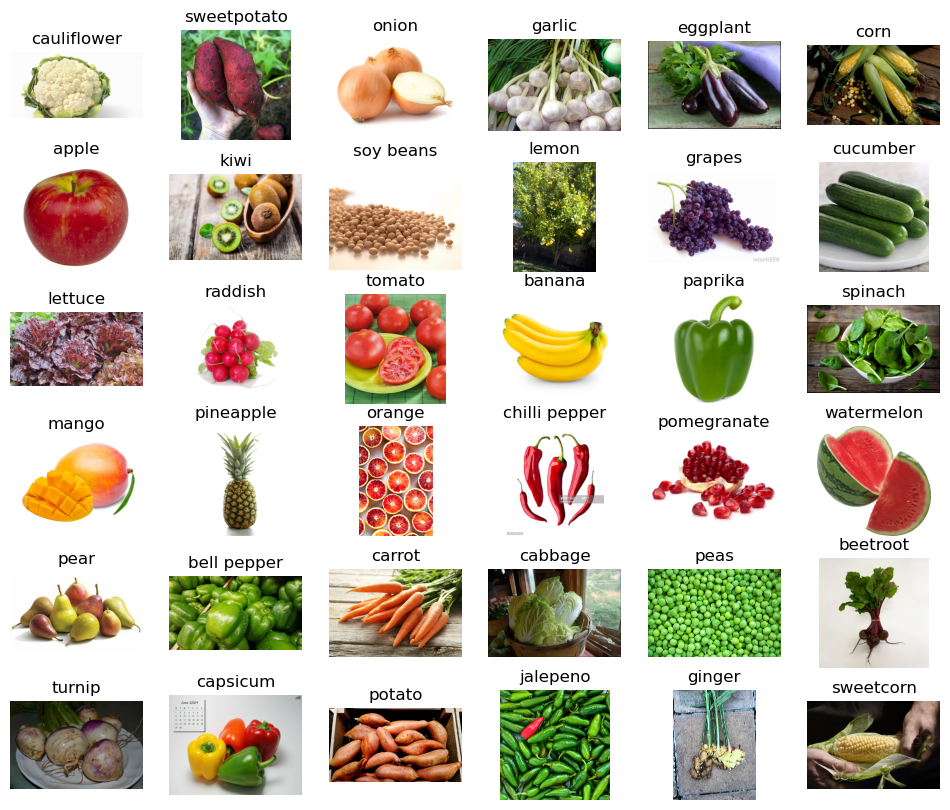

In [56]:
visualize_class_distribution(train_df)
show_example_images(train_df)

In [57]:
def extract_hog_features(image_path, img_size=(128, 128)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img = np.array(img)
    
    # Проверяем, что изображение в RGB формате
    if len(img.shape) == 3 and img.shape[2] == 3:
        # Извлекаем признаки HOG
        fd = hog(img, orientations=9, pixels_per_cell=(8, 8), 
                 cells_per_block=(2, 2), visualize=False, channel_axis=-1)
        return fd
    else:
        return None  # Если изображение не в правильном формате, возвращаем None


In [58]:
def add_features_to_df(df):
    # Инициализируем список для хранения HOG-признаков для каждого изображения
    features = []
    # Проходим по каждому пути к файлу в DataFrame
    for filepath in df['Filepath']:
        # Извлекаем HOG-признаки для изображения
        hog_features = extract_hog_features(filepath)

        # Если признаки успешно извлечены, добавляем их в список
        if hog_features is not None:
            features.append(hog_features)
        else:
            features.append(np.zeros((3780,))) 
    # Преобразуем список HOG-признаков в DataFrame
    feature_df = pd.DataFrame(features)
    return pd.concat([df, feature_df], axis=1)

# Применяем к каждому набору данных
train_df = add_features_to_df(train_df)
test_df = add_features_to_df(test_df)
val_df = add_features_to_df(val_df)


In [59]:
#Преобразуем метки в числовые значения
le = LabelEncoder()

train_df['Label_encoded'] = le.fit_transform(train_df['Label'])
test_df['Label_encoded'] = le.transform(test_df['Label'])
val_df['Label_encoded'] = le.transform(val_df['Label'])


In [60]:
# Извлекаем признаки , исключая ненужные столбцы
X_train = train_df.drop(columns=['Filepath', 'Label', 'Label_encoded'])
y_train = train_df['Label_encoded']

X_test = test_df.drop(columns=['Filepath', 'Label', 'Label_encoded'])
y_test = test_df['Label_encoded']

X_val = val_df.drop(columns=['Filepath', 'Label', 'Label_encoded'])
y_val = val_df['Label_encoded']


In [61]:
# Создаем и обучаем модель
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [65]:
# Предсказания на тестовой выборке
y_pred_test = clf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Предсказания на валидационной выборке
y_pred_val = clf.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print('Точность на тестовой выборке: %.2f%%' % (accuracy_test*100))
print('Точность на валидационной выборке: %.2f%%' % (accuracy_val*100))

Точность на тестовой выборке: 96.76%
Точность на валидационной выборке: 96.76%


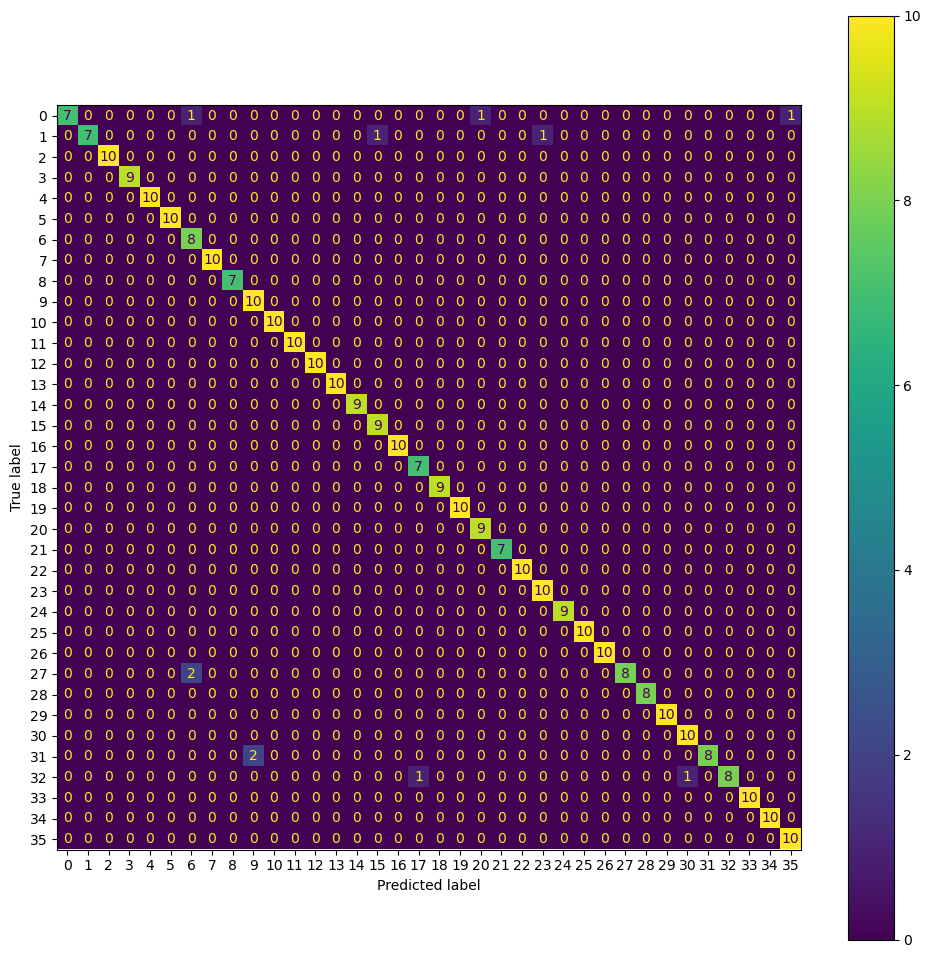

In [75]:
# Построение матрицы ошибок для модели на тестовой выборке
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=ax)

In [76]:
def predict_image(model, img_path, img_size=(128, 128)):
    # Извлекаем HOG-признаки для нового изображения
    hog_features = extract_hog_features(img_path, img_size=img_size)
    if hog_features is not None:
        hog_features = np.array(hog_features).reshape(1, -1)
        pred = model.predict(hog_features)
        label = le.inverse_transform(pred)
        return label[0]
    else:
        return 'Invalid image format'


In [77]:
import joblib

# Сохраняем модель в файл
model_filename = 'fruit_classifier_model.joblib'
joblib.dump(clf, model_filename)

print(f'Model saved to {model_filename}')


Model saved to fruit_classifier_model.joblib


In [79]:
# Загрузка модели из файла
loaded_model = joblib.load(model_filename)

# Использование загруженной модели для предсказания
new_img_path = 'fruits\\validation\\onion\\Image_3.JPG'
predicted_fruit = predict_image(loaded_model, new_img_path)
print(f'Predicted fruit: {predicted_fruit}')


Predicted fruit: onion
